# 장애인콜택시 대기시간 예측
## 단계1.데이터 전처리

## 0.미션

* 1.데이터를 탐색하며 정보 획득
    * 데이터는 2015-01-01 ~ 2022-12-31 까지의 서울 장애인 콜택시 운행 정보입니다. 우리는 평균대기시간을 예측하고자 합니다. 
    * 요일, 월, 계절, 연도별 운행 정보에 어떤 주기와 변화가 있는지 탐색해 봅시다.
* 2.분석을 위한 데이터 구조 만들기
    * 문제정의 : 
        * 전 날 콜택시 운행이 종료되었을 때, 다음 날 대기시간을 예측하고자 합니다.

        * 만약 다음 날 대기시간을 예측할 수 있다면, 일정 범위 내에서 배차를 조절할 수 있을 뿐만 아니라, 향후 교통약자의 이동 편의 증진을 위한 정책 수립 및 개선에 기여할 수 있습니다. 
    * 이를 위한 데이터 구조를 만들어 봅시다.
        * 분석 단위는 일별 데이터 입니다.
        * 주어진 데이터 : 장애인 콜택시 운행 정보, 서울시 날씨
        * 날씨 데이터는 실제 측정값이지만, 다음 날에 대한 예보 데이터로 간주합니다. 
            * 예를 들어, 
                * 2020-12-23 의 날씨 데이터는 전 날(12월22일) 날씨예보 데이터로 간주하여 분석을 수행합니다.
                * 2020-12-22일의 장애인 이동 데이터로 23일의 대기시간을 예측해야 하며, 이때 고려할 날씨데이터는 23일 데이터 입니다.
        * 장애인 이동 데이터를 기준으로 날씨 데이터를 붙여서 만듭시다.
        * 휴무일 데이터는 패키지를 통해서 다운받아 사용합니다.
    * Feature Engineering
        * 대기시간에 영향을 주는 요인을 도출하고(가설수립) 이를 feature로 생성합시다.
        * 주어진 그대로의 데이터가 아닌 새로운 feature를 생성해 봅시다.
            * 날짜와 관련된 feature : 요일, 월, 계절 ... 
            * 시계열 특성이 반영된 feature : 최근 7일간의 평균 대기시간 ...




## 1.환경설정

### (1) 라이브러리 불러오기

* **세부 요구사항**
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

# 더 필요한 라이브러리를 아래에 추가합니다.



### (2) 데이터 로딩
* 주어진 데이터셋
    * 장애인 콜택시 운행 정보 : open_data.csv
    * 날씨 데이터 : weather.csv
* 다음의 두가지 방법 중 하나를 선택하시오.
    * 1) 로컬 수행(Ananconda)
        * 제공된 압축파일을 다운받아 압축을 풀고
        * anaconda의 root directory(보통 C:/Users/< ID > 에 project 폴더를 만들고, 복사해 넣습니다.
    * 2) 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고, 
        * 데이터 파일을 복사해 넣습니다.

#### 2) 구글 콜랩 수행

* 구글 드라이브 연결

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
path = '/content/drive/MyDrive/AIVLE/0417-0420/'


#### 3) 데이터 읽어오기

In [8]:
file1 = pd.read_csv(path + 'open_data.csv')
file2 = pd.read_csv(path + 'weather.csv')

In [9]:
file1.head(5)

,기준일,차량운행,접수건,탑승건,평균대기시간,평균요금,평균승차거리
0,2015-01-01,213,1023,924,23.2,2427,10764
1,2015-01-02,420,3158,2839,17.2,2216,8611
2,2015-01-03,209,1648,1514,26.2,2377,10198
3,2015-01-04,196,1646,1526,24.5,2431,10955
4,2015-01-05,421,4250,3730,26.2,2214,8663


In [10]:
file1['Date']=file1['기준일']

In [11]:
file1 = file1.drop('기준일', axis=1)

In [12]:
file2['Date'] = file2['Date'].shift(1)

In [13]:
file2

,Date,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2)
0,None,0.4,-6.6,0.0,77.0,45.0,4.90
1,2012-01-01,-1.2,-8.3,0.0,80.0,48.0,6.16
2,2012-01-02,-0.4,-6.6,0.4,86.0,45.0,4.46
3,2012-01-03,-4.6,-9.5,0.0,66.0,38.0,8.05
4,2012-01-04,-1.4,-9.6,0.0,71.0,28.0,9.14
...,...,...,...,...,...,...,...
4013,2022-12-26,3.0,-7.3,0.0,86.0,51.0,10.25
4014,2022-12-27,-0.3,-5.4,0.1,92.0,40.0,10.86
4015,2022-12-28,1.7,-7.8,0.0,71.0,34.0,10.88
4016,2022-12-29,2.1,-4.0,0.0,87.0,38.0,10.84


In [14]:
file2

,Date,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2)
0,None,0.4,-6.6,0.0,77.0,45.0,4.90
1,2012-01-01,-1.2,-8.3,0.0,80.0,48.0,6.16
2,2012-01-02,-0.4,-6.6,0.4,86.0,45.0,4.46
3,2012-01-03,-4.6,-9.5,0.0,66.0,38.0,8.05
4,2012-01-04,-1.4,-9.6,0.0,71.0,28.0,9.14
...,...,...,...,...,...,...,...
4013,2022-12-26,3.0,-7.3,0.0,86.0,51.0,10.25
4014,2022-12-27,-0.3,-5.4,0.1,92.0,40.0,10.86
4015,2022-12-28,1.7,-7.8,0.0,71.0,34.0,10.88
4016,2022-12-29,2.1,-4.0,0.0,87.0,38.0,10.84


In [15]:
file2.drop(0)

,Date,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2)
1,2012-01-01,-1.2,-8.3,0.0,80.0,48.0,6.16
2,2012-01-02,-0.4,-6.6,0.4,86.0,45.0,4.46
3,2012-01-03,-4.6,-9.5,0.0,66.0,38.0,8.05
4,2012-01-04,-1.4,-9.6,0.0,71.0,28.0,9.14
5,2012-01-05,1.3,-4.8,0.0,55.0,27.0,8.57
...,...,...,...,...,...,...,...
4013,2022-12-26,3.0,-7.3,0.0,86.0,51.0,10.25
4014,2022-12-27,-0.3,-5.4,0.1,92.0,40.0,10.86
4015,2022-12-28,1.7,-7.8,0.0,71.0,34.0,10.88
4016,2022-12-29,2.1,-4.0,0.0,87.0,38.0,10.84


In [16]:
data = pd.merge(file1,file2, on='Date', how='inner')

In [17]:
data

,차량운행,접수건,탑승건,평균대기시간,평균요금,평균승차거리,Date,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2)
0,213,1023,924,23.2,2427,10764,2015-01-01,-2.0,-8.9,0.0,63.0,28.0,9.07
1,420,3158,2839,17.2,2216,8611,2015-01-02,2.4,-9.2,0.0,73.0,37.0,8.66
2,209,1648,1514,26.2,2377,10198,2015-01-03,8.2,0.2,0.0,89.0,58.0,5.32
3,196,1646,1526,24.5,2431,10955,2015-01-04,7.9,-0.9,0.0,95.0,52.0,6.48
4,421,4250,3730,26.2,2214,8663,2015-01-05,4.1,-7.4,3.4,98.0,29.0,10.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2916,603,5555,4605,39.2,2163,7889,2022-12-26,3.0,-7.3,0.0,86.0,51.0,10.25
2917,669,5635,4654,44.4,2198,8178,2022-12-27,-0.3,-5.4,0.1,92.0,40.0,10.86
2918,607,5654,4648,44.8,2161,7882,2022-12-28,1.7,-7.8,0.0,71.0,34.0,10.88
2919,581,5250,4247,52.5,2229,8433,2022-12-29,2.1,-4.0,0.0,87.0,38.0,10.84


#### 4) 기본정보 확인하기
* .info() 등을 이용하여 기본 정보를 확인합니다.

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2921 entries, 0 to 2920
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   차량운행             2921 non-null   int64  
 1   접수건              2921 non-null   int64  
 2   탑승건              2921 non-null   int64  
 3   평균대기시간           2921 non-null   float64
 4   평균요금             2921 non-null   int64  
 5   평균승차거리           2921 non-null   int64  
 6   Date             2921 non-null   object 
 7   temp_max         2921 non-null   float64
 8   temp_min         2921 non-null   float64
 9   rain(mm)         2921 non-null   float64
 10  humidity_max(%)  2921 non-null   float64
 11  humidity_min(%)  2921 non-null   float64
 12  sunshine(MJ/m2)  2921 non-null   float64
dtypes: float64(7), int64(5), object(1)
memory usage: 319.5+ KB


In [19]:
data.shape

(2921, 13)

In [20]:
data.dtypes

차량운행                 int64
접수건                  int64
탑승건                  int64
평균대기시간             float64
평균요금                 int64
평균승차거리               int64
Date                object
temp_max           float64
temp_min           float64
rain(mm)           float64
humidity_max(%)    float64
humidity_min(%)    float64
sunshine(MJ/m2)    float64
dtype: object

#### 5) 칼럼이름을 영어로 변경
* 꼭 필요한 작업은 아니지만, 데이터를 편리하게 다루고 차트에서 불필요한 경고메시지를 띄우지 않게 하기 위해 영문으로 변경하기를 권장합니다.


## 2.데이터 기본 탐색

* **세부요구사항**
    * 날짜 요소에 따라 각 정보의 패턴을 조회 합니다.
        * 일별, 요일별, 주차별, 월별, 연도별
        * 접수건, 탑승건, 거리, 요금, 대기시간 등
    * 제시된 범위 외에 가능하다면 추가 탐색을 시도합니다.

### (1) 주기별 분석을 위해서 날짜 변수 추가하기
* data를 복사합니다.
* 복사한 df에 요일, 주차, 월, 연도 등을 추가합니다.

In [21]:
df= data.copy()

In [22]:
df['Date'] = pd.to_datetime(df['Date'])

In [23]:
df['dayofweek'] = df['Date'].dt.dayofweek
df['week'] = df['Date'].dt.week
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year

<ipython-input-23-1b80901f9a82>:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['week'] = df['Date'].dt.week


In [24]:
df

,차량운행,접수건,탑승건,평균대기시간,평균요금,평균승차거리,Date,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),dayofweek,week,month,year
0,213,1023,924,23.2,2427,10764,2015-01-01,-2.0,-8.9,0.0,63.0,28.0,9.07,3,1,1,2015
1,420,3158,2839,17.2,2216,8611,2015-01-02,2.4,-9.2,0.0,73.0,37.0,8.66,4,1,1,2015
2,209,1648,1514,26.2,2377,10198,2015-01-03,8.2,0.2,0.0,89.0,58.0,5.32,5,1,1,2015
3,196,1646,1526,24.5,2431,10955,2015-01-04,7.9,-0.9,0.0,95.0,52.0,6.48,6,1,1,2015
4,421,4250,3730,26.2,2214,8663,2015-01-05,4.1,-7.4,3.4,98.0,29.0,10.47,0,2,1,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2916,603,5555,4605,39.2,2163,7889,2022-12-26,3.0,-7.3,0.0,86.0,51.0,10.25,0,52,12,2022
2917,669,5635,4654,44.4,2198,8178,2022-12-27,-0.3,-5.4,0.1,92.0,40.0,10.86,1,52,12,2022
2918,607,5654,4648,44.8,2161,7882,2022-12-28,1.7,-7.8,0.0,71.0,34.0,10.88,2,52,12,2022
2919,581,5250,4247,52.5,2229,8433,2022-12-29,2.1,-4.0,0.0,87.0,38.0,10.84,3,52,12,2022


### (2) 일별

* 차량 운행수

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50868 (\N{HANGUL SYLLABLE UN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54665 (\N{HANGUL SYLLABLE HAENG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


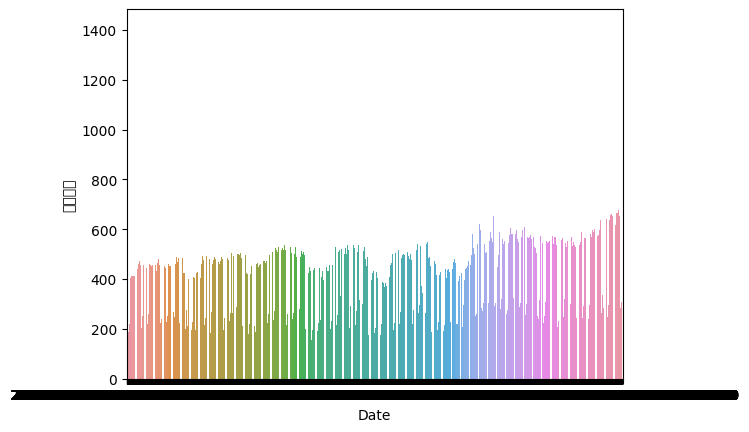

In [ ]:
sns.barplot(data=df, x="Date", y="차량운행")
plt.show()

* 접수건, 탑승건

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51217 (\N{HANGUL SYLLABLE JEOB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


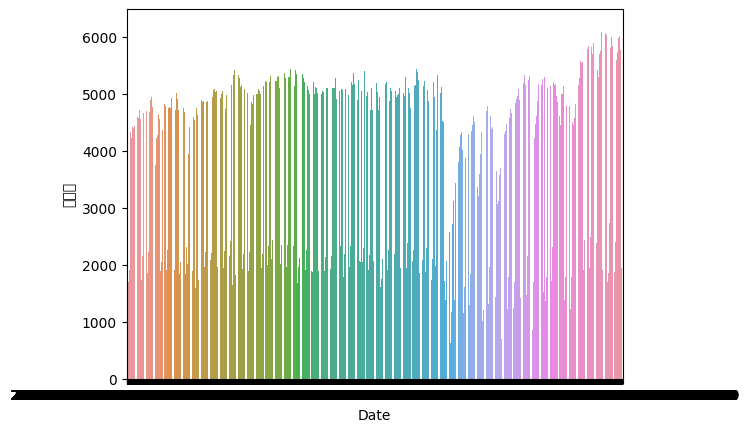

In [ ]:
sns.barplot(data=df, x="Date", y="접수건")
plt.show()

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53457 (\N{HANGUL SYLLABLE TAB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49849 (\N{HANGUL SYLLABLE SEUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


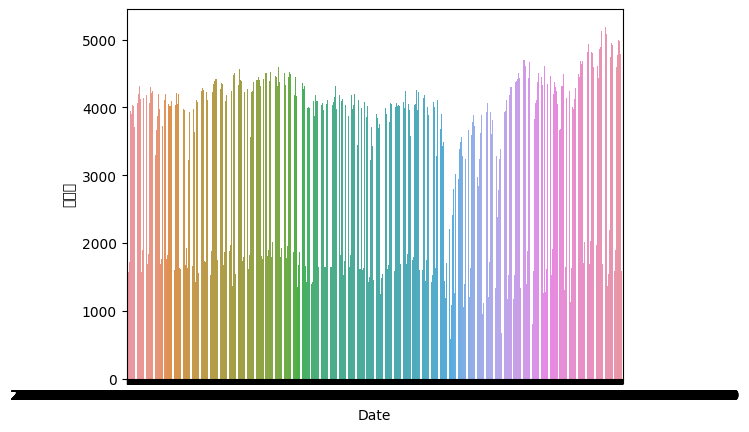

In [ ]:
sns.barplot(data=df, x="Date", y="탑승건")
plt.show()

* 대기시간

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPyt

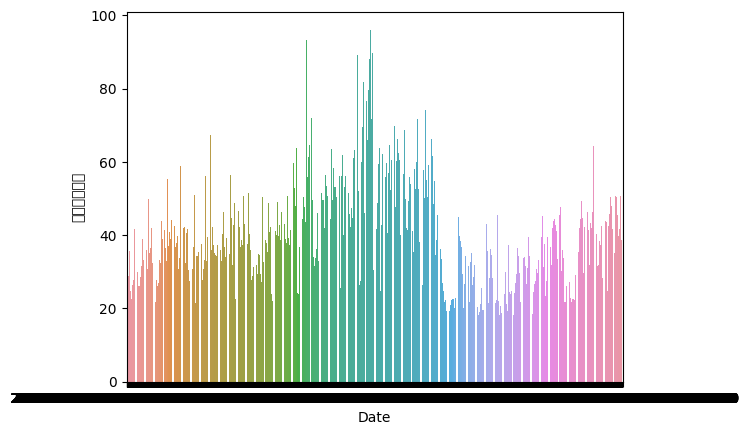

In [ ]:
sns.barplot(data=df, x="Date", y="평균대기시간")
plt.show()

* 운임

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


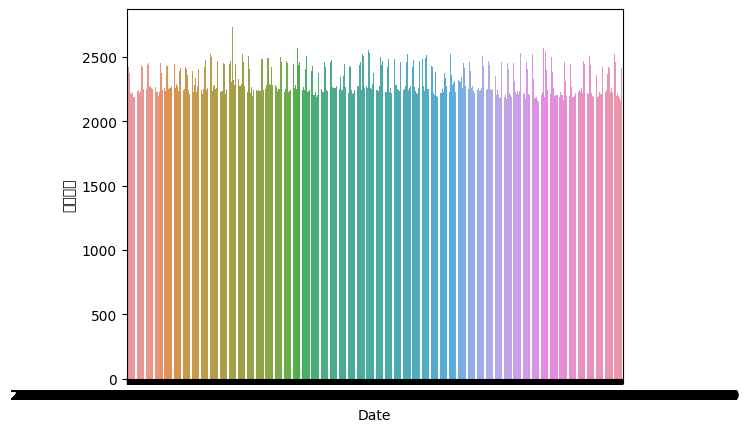

In [ ]:
sns.barplot(data=df, x="Date", y="평균요금")
plt.show()

* 이동거리

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49849 (\N{HANGUL SYLLABLE SEUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44144 (\N{HANGUL SYLLABLE GEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/I

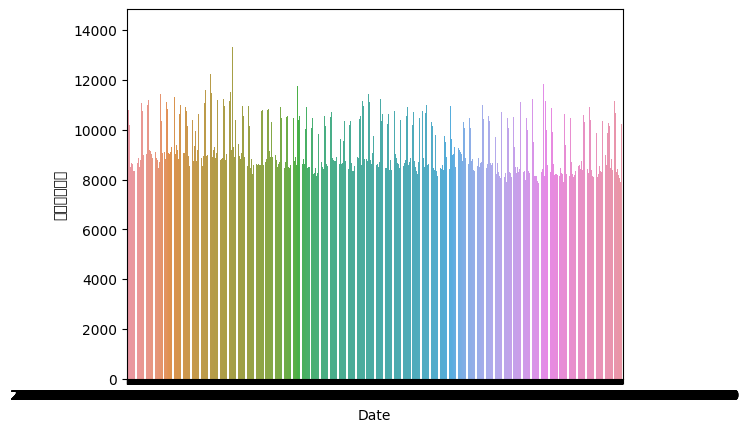

In [ ]:
sns.barplot(data=df, x="Date", y="평균승차거리")
plt.show()

### (3) 요일별

* 차량 운행수

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50868 (\N{HANGUL SYLLABLE UN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54665 (\N{HANGUL SYLLABLE HAENG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


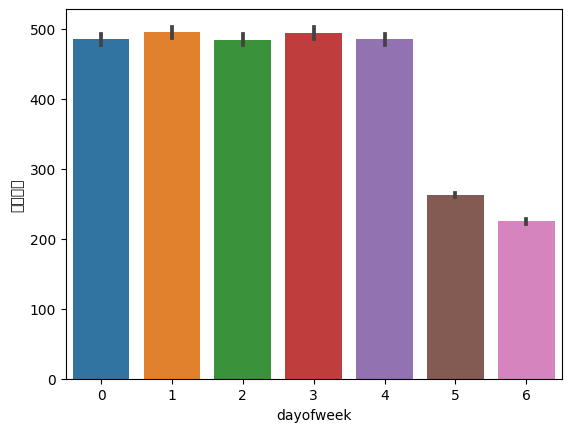

In [ ]:
sns.barplot(data=df, x="dayofweek", y="차량운행")
plt.show()

* 접수건, 탑승건

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51217 (\N{HANGUL SYLLABLE JEOB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


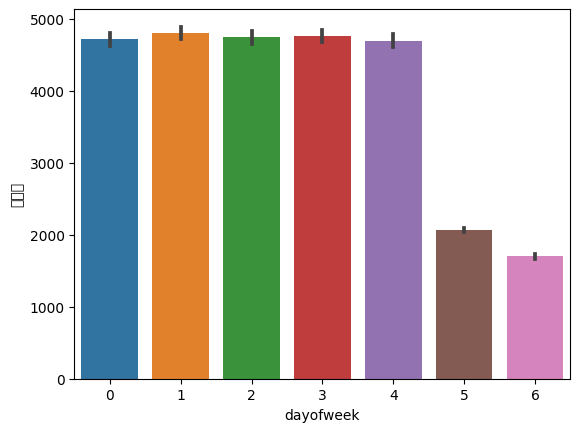

In [ ]:
sns.barplot(data=df, x="dayofweek", y="접수건")
plt.show()

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53457 (\N{HANGUL SYLLABLE TAB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49849 (\N{HANGUL SYLLABLE SEUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


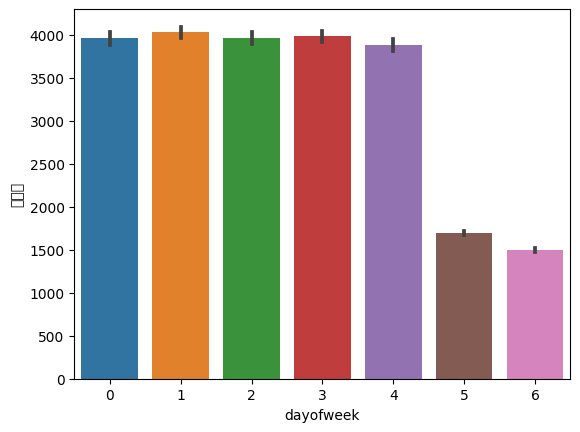

In [ ]:
sns.barplot(data=df, x="dayofweek", y="탑승건")
plt.show()

* 대기시간

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPyt

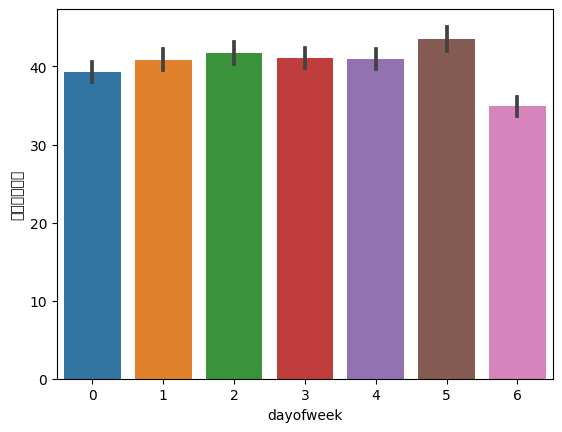

In [ ]:
sns.barplot(data=df, x="dayofweek", y="평균대기시간")
plt.show()

* 운임

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


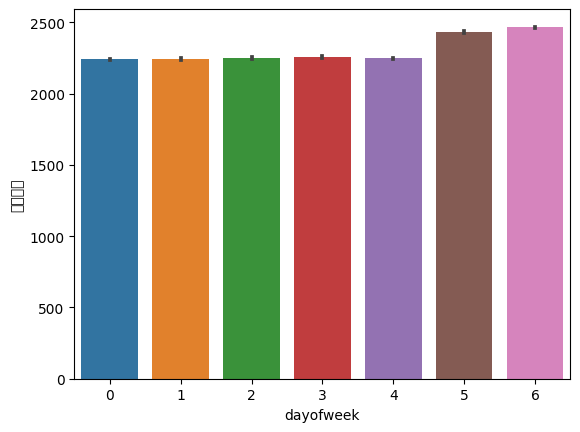

In [ ]:
sns.barplot(data=df, x="dayofweek", y="평균요금")
plt.show()

* 이동거리

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49849 (\N{HANGUL SYLLABLE SEUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44144 (\N{HANGUL SYLLABLE GEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/I

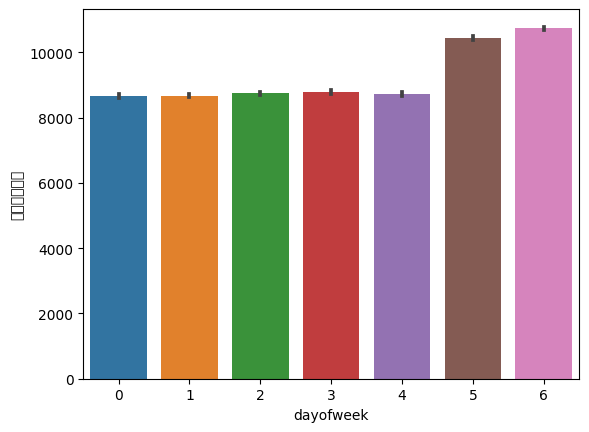

In [ ]:
sns.barplot(data=df, x="dayofweek", y="평균승차거리")
plt.show()

### (4) 월별

* 차량 운행수

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50868 (\N{HANGUL SYLLABLE UN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54665 (\N{HANGUL SYLLABLE HAENG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


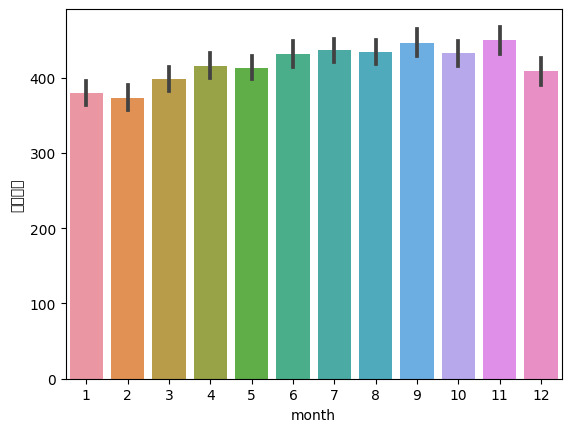

In [ ]:
sns.barplot(data=df, x="month", y="차량운행")
plt.show()

* 접수건, 탑승건

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51217 (\N{HANGUL SYLLABLE JEOB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


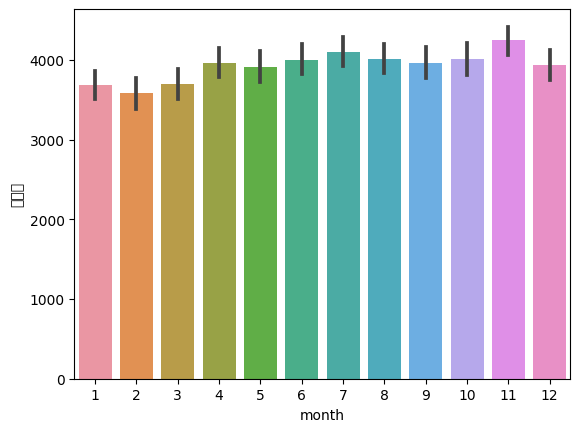

In [ ]:
sns.barplot(data=df, x="month", y="접수건")
plt.show()

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53457 (\N{HANGUL SYLLABLE TAB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49849 (\N{HANGUL SYLLABLE SEUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


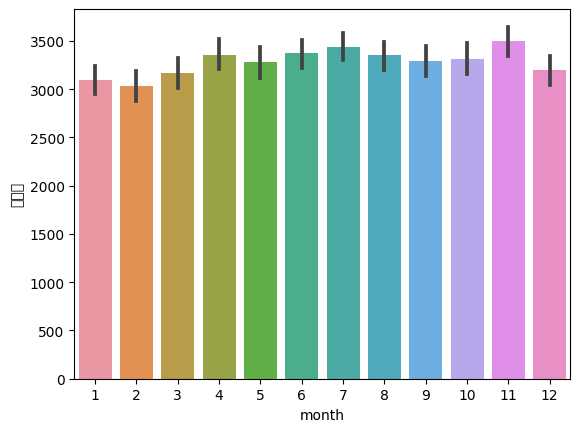

In [ ]:
sns.barplot(data=df, x="month", y="탑승건")
plt.show()

* 대기시간

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPyt

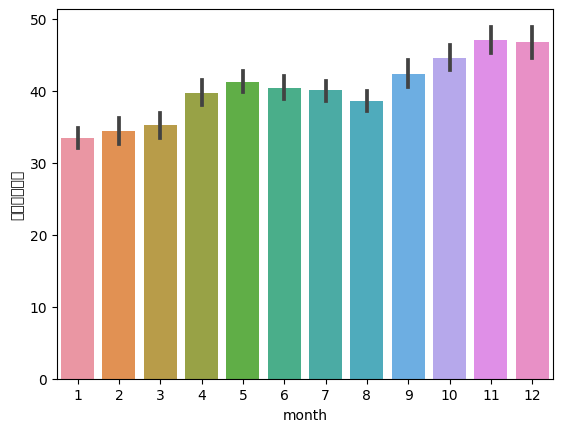

In [ ]:
sns.barplot(data=df, x="month", y="평균대기시간")
plt.show()

* 운임

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


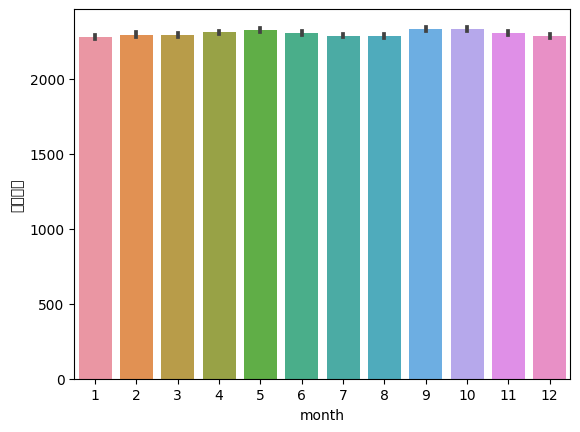

In [ ]:
sns.barplot(data=df, x="month", y="평균요금")
plt.show()

* 이동거리

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49849 (\N{HANGUL SYLLABLE SEUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44144 (\N{HANGUL SYLLABLE GEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/I

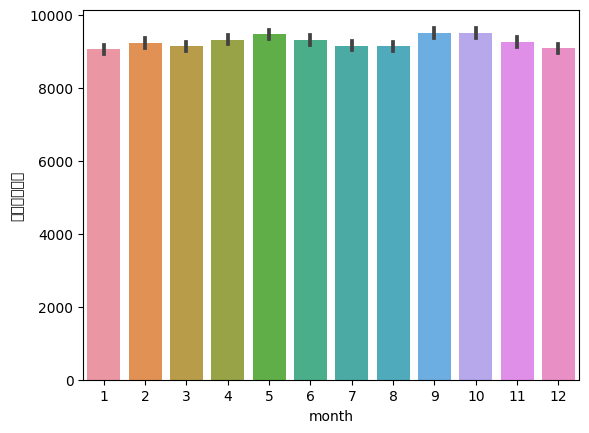

In [ ]:
sns.barplot(data=df, x="month", y="평균승차거리")
plt.show()

### (5) 연도별

* 차량 운행수

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50868 (\N{HANGUL SYLLABLE UN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54665 (\N{HANGUL SYLLABLE HAENG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


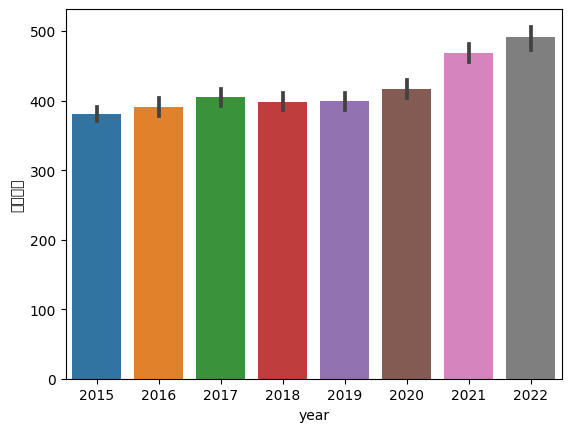

In [ ]:
sns.barplot(data=df, x="year", y="차량운행")
plt.show()

* 대기시간

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPyt

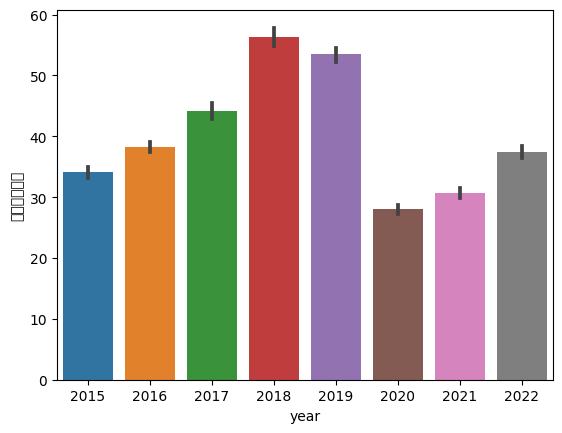

In [ ]:
sns.barplot(data=df, x="year", y="평균대기시간")
plt.show()

## 3.데이터 구조 만들기

* **세부요구사항**
    * 조건 : 
        * 목표 : 전날 저녁, 다음날 평균 대기시간을 예측하고자 합니다.
        * 날씨 데이터는 실제 측정값이지만, 다음 날에 대한 예보 데이터로 간주합니다. 
            * 예를 들어, 
                * 2020-12-23 의 날씨 데이터는 전날(12월22일) 날씨예보 데이터로 간주하여 분석을 수행합니다.
                * 2020-12-22일의 장애인 이동 데이터로 23일의 대기시간을 예측해야 하며, 이때 고려할 날씨데이터는 23일 데이터 입니다.
    * 장애인 이동 데이터를 기준으로 날씨 데이터를 붙입니다.

### (1) target 만들기
* 예측하는 날짜, 대기시간(target)으로 기준을 잡습니다.

### (2) 날씨 데이터 붙이기
* merge를 활용합니다. 기준은 운행정보 입니다.

### (3) 새로운 feature를 생성해 봅시다.
* 날짜와 관련된 변수 추가하기 : 요일, 월, 계절, 연도
* 그외 새로운 feature 도출 : 최소 2개 이상
    * 예 : 공휴일, 최근 7주일간의 평균 대기시간, 탑승률 등

#### 1) 날짜와 관련된 변수 추가하기 : 요일, 월, 계절, 연도
* 요일 이름, 계절이름, 월 이름으로 만드는 경우에는, 변수를 pd.Categorical로 범주형을 만들면서 순서를 지정하는 것이 이후 그래프를 그릴 때 순서대로 표현할 수 있습니다.


#### 2) 공휴일 정보
* workalendar 패키지를 설치하고, 대한민국 공휴일 정보를 끌어와 봅시다.

* 휴무일 데이터 패키지 설치

In [ ]:
!pip install workalendar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 4.2 MB/s eta 0:00:00


* 간단 사용법

In [ ]:
from workalendar.asia import SouthKorea
cal = SouthKorea()
pd.DataFrame(cal.holidays(2023))

,0,1
0,2023-01-01,New year
1,2023-01-21,Korean New Year's Day
2,2023-01-22,Korean New Year's Day
3,2023-01-23,Korean New Year's Day
4,2023-03-01,Independence Day
5,2023-05-05,Children's Day
6,2023-05-26,Buddha's Birthday
7,2023-06-06,Memorial Day
8,2023-08-15,Liberation Day
9,2023-09-28,Midautumn Festival


* 휴무일 데이터셋 만들기 2015 ~ 2022
* 실제로 휴무일에 해당하지만 workalendar 라이브러리에 없는 날짜는 직접 추가해봅시다.
    * 휴무일 장애인 콜택시의 접수건 변화에 대한 특징을 찾아 이를 바탕으로 데이터를 조회하여 찾아볼 수 있음

* 기존 데이터에 휴무일 정보 결합하기.
* 휴무일이 아닌 날짜는 0으로 저장하시오.

In [ ]:
hol = pd.DataFrame(cal.holidays(2023))

In [ ]:
hol[1]=1

In [6]:
hol

NameError: ignored

In [ ]:
hol.rename(columns={0})

In [2]:
pd.merge(df, hol, axis=1, )

NameError: ignored

#### 3) 7일 이동평균 대기시간
* rolling().mean() 사용

#### 4) 탑승률

## 4.데이터 저장
* **세부요구사항**
    * joblib 을 사용하여 작업 경로에 정리한 데이터프레임을 저장합니다.
        * 저장파일이름 : data1.pkl